In [2]:
import sys
#sys.path.append("C:\\Users\\jafaja24\\QuantProject\\pkgs")
#print(sys.path)

import blpapi
from xbbg import blp
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random

## Loading data from csvs

In [3]:
start_date = '2022-01-01'
end_date = '2024-12-31'

index_name = 'SX5E'
hist_data = pd.read_csv('stx/'+index_name+'_index.csv', index_col=0)
hist_data = hist_data.dropna(axis=1, how='any')

tickers = hist_data.columns.tolist()
print(tickers)

['ABI BB Equity', 'AD NA Equity', 'ADYEN NA Equity', 'AI FP Equity', 'AIR FP Equity', 'ASML NA Equity', 'BBVA SQ Equity', 'BN FP Equity', 'BNP FP Equity', 'CS FP Equity', 'DG FP Equity', 'EL FP Equity', 'IBE SQ Equity', 'INGA NA Equity', 'ITX SQ Equity', 'KER FP Equity', 'MC FP Equity', 'OR FP Equity', 'PRX NA Equity', 'RI FP Equity', 'RMS FP Equity', 'SAF FP Equity', 'SAN FP Equity', 'SAN SQ Equity', 'SGO FP Equity', 'SU FP Equity', 'TTE FP Equity', 'WKL NA Equity']


log of prices, for stationarity

In [4]:
log_prices = np.log(hist_data)
returns = hist_data.pct_change().dropna()
prices = hist_data.dropna()
log_returns = log_prices.diff().dropna()

In [5]:
form_start = '2022-01-01'
form_end = '2023-12-31'
trade_start = '2024-01-01'
trade_end = '2024-07-01'

returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]
prices_trade = prices.loc[trade_start:trade_end]
log_prices_form = log_prices.loc[form_start:form_end]
log_prices_trade = log_prices.loc[trade_start:trade_end]

p-value = 0.05

In [6]:
selected_pairs = []
selected_stocks = []

for t1 in tickers:
    for t2 in tickers:
        if (t1!=t2) and (t1 not in selected_stocks) and (t2 not in selected_stocks):
            if (coint(log_prices_form[t1], log_prices_form[t2])[1] < 0.05):
                selected_stocks.append(t1)
                selected_stocks.append(t2)
                selected_pairs.append(f'{t1}-{t2}')

In [7]:
print(selected_pairs)

['AD NA Equity-MC FP Equity', 'AI FP Equity-AIR FP Equity', 'ASML NA Equity-BBVA SQ Equity', 'BNP FP Equity-SU FP Equity', 'CS FP Equity-EL FP Equity', 'DG FP Equity-ITX SQ Equity', 'INGA NA Equity-SAF FP Equity', 'TTE FP Equity-ADYEN NA Equity']


In [8]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [9]:
def calculate_metrics(cumret, n_days):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    rets = pd.DataFrame(cumret).pct_change().dropna()
    sharpe = np.sqrt(n_days) * np.nanmean(rets) / np.nanstd(rets)
    # value at risk
    confidence_level = 0.95
    var = np.percentile(rets.values.flatten(), (1 - confidence_level) * 100)  # Convert to 1D array
    print(n_days, " trading days in total!")
    return total_return, sharpe, var

## 1st Half-Year Trades (Jan to June)

In [11]:
# Parameters
r = 1.25  # Standard deviation threshold

def get_positions():
    positions = pd.DataFrame(index=prices_trade.index, columns=selected_stocks)  # Combined positions
    
    for pair in selected_pairs:
        s1, s2 = parse_pair(pair)
        # Calculate parameters using historical data
        model = sm.OLS(log_prices_form[s1], sm.add_constant(log_prices_form[s2]))
        res = model.fit()
        mu = res.resid.mean()  # Spread historical mean
        sigma = res.resid.std()  # Spread historical standard deviation
        spread = log_prices_trade[s1] - res.predict(sm.add_constant(log_prices_trade[s2]))

        # Initialize the position
        position = 0

        # Iterate through the time index
        for t in prices_trade.index:
            if spread[t] > mu + r * sigma:
                if position != -1:  # Only enter short if not already short
                    positions.loc[t, [s1, s2]] = [-1, 1]
                    position = -1
                else:
                    positions.loc[t, [s1, s2]] = [position, -position]  # Hold

            elif spread[t] < mu - r * sigma:
                if position != 1:  # Only enter long if not already long
                    positions.loc[t, [s1, s2]] = [1, -1]
                    position = 1
                else:
                    positions.loc[t, [s1, s2]] = [position, -position]  # Hold

            else:
                # No signal: hold current position
                positions.loc[t, [s1, s2]] = [position, -position]

    # Fill NaN values to ensure all rows have positions
    positions.fillna(0, inplace=True)
    
    return positions

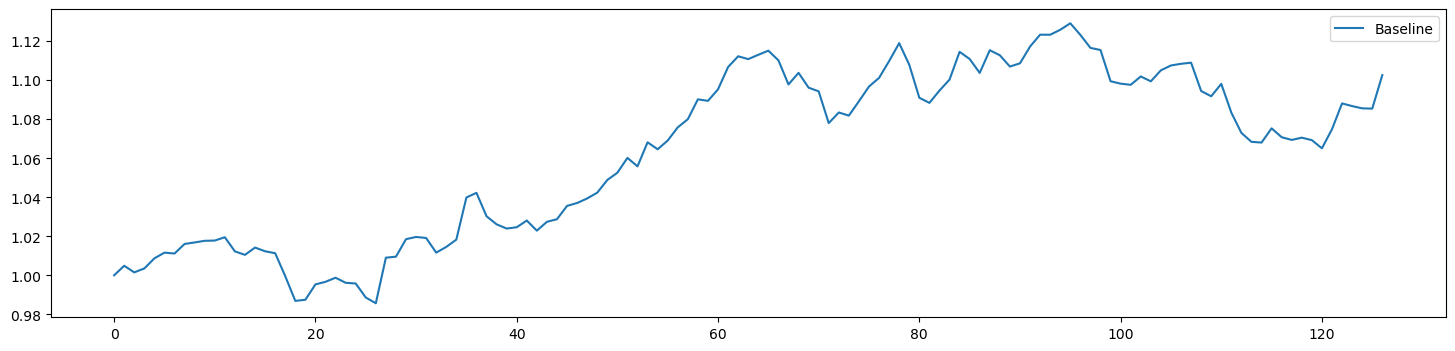

In [12]:
# calculate returns
positions = get_positions()
ret = (positions.shift() * returns_trade[selected_stocks]).sum(axis=1)/len(selected_pairs)
cumret = np.nancumprod(ret + 1)

# plot returns 
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Baseline')
plt.legend()

In [13]:
# extract results
results_df = pd.DataFrame(columns=['TPR', 'Sharpe', 'VaR (95%)'])
tpr_3m, sharpe_3m, var_3m = calculate_metrics(cumret, len(cumret))
results_df.loc['pairs'] = tpr_3m, sharpe_3m, var_3m

127  trading days in total!


In [14]:
results_df

,TPR,Sharpe,VaR (95%)
pairs,0.10265,1.354023,-0.011606


## 2nd Half-Year Trades (Jul to Dec)

In [15]:
form_start = '2022-01-01'
form_end = '2023-12-31'
trade_start = '2024-07-02'
trade_end = '2024-12-31'

returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]
prices_trade = prices.loc[trade_start:trade_end]
log_prices_form = log_prices.loc[form_start:form_end]
log_prices_trade = log_prices.loc[trade_start:trade_end]

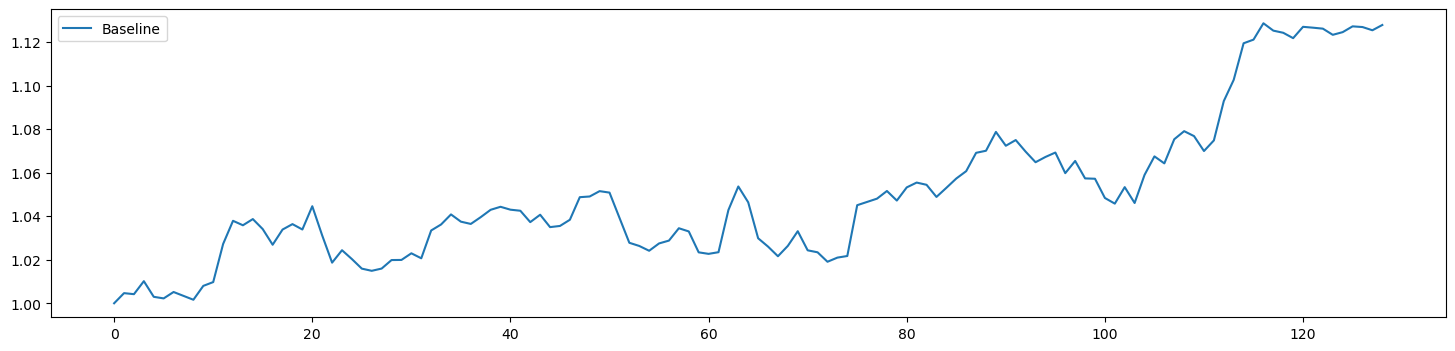

In [16]:
# calculate returns
positions = get_positions()
ret = (positions.shift() * returns_trade[selected_stocks]).sum(axis=1)/len(selected_pairs)
cumret = np.nancumprod(ret + 1)

# plot returns 
plt.figure(figsize=(18,4))
plt.plot(cumret, label='Baseline')
plt.legend()

In [17]:
# again extract results
results_df = pd.DataFrame(columns=['TPR', 'Sharpe', 'VaR (95%)'])
tpr_9m, sharpe_9m, var_9m = calculate_metrics(cumret, len(cumret))
results_df.loc['pairs'] = tpr_9m, sharpe_9m, var_9m

129  trading days in total!


In [18]:
results_df

,TPR,Sharpe,VaR (95%)
pairs,0.127858,1.714828,-0.008734


In [19]:
previous_positions = positions.shift(1)

In [20]:
# positions
# uncomment the above to see positions taken

## Save results

In [21]:
def save_metrics_to_csv(index_name, r, tpr_3m, sharpe_3m, tpr_9m, sharpe_9m, file_path):
    df = pd.DataFrame(columns=['Index', 'Threshold (r)', '3M TPR', '3M Sharpe', '9M TPR', '9M Sharpe'])
    new_row = pd.DataFrame({'Index': [index_name],'Threshold (r)': [r],'3M TPR': [tpr_3m],'3M Sharpe': [sharpe_3m],'9M TPR': [tpr_9m],'9M Sharpe': [sharpe_9m]})
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(file_path, index=False)

file_path = 'results.csv'
# save_metrics_to_csv(index_name, r, tpr_3m, sharpe_3m, tpr_9m, sharpe_9m, file_path)
# save results if u want, pretty pointless actually - was needed for debugging and analysis

## Other Plots

In [22]:
position_history = []

previous_positions = positions.shift(1)  # Shift the positions by 1 to compare with the previous day

for t in positions.index:
    for pair in selected_pairs:
        s1, s2 = parse_pair(pair)

        # Compare the current position with the previous position
        current_position_s1 = positions.loc[t, s1]
        current_position_s2 = positions.loc[t, s2]
        previous_position_s1 = previous_positions.loc[t, s1]
        previous_position_s2 = previous_positions.loc[t, s2]

        if current_position_s1 == 0 or current_position_s2 == 0:
            continue
        
        # Check if there is a change in position for stock 1 or stock 2
        if current_position_s1 != previous_position_s1 or current_position_s2 != previous_position_s2:
            position_type = 'Long' if current_position_s1 == 1 else 'Short'
            position_history.append([t, pair, position_type])

position_history_df = pd.DataFrame(position_history, columns=['Date', 'Pair', 'Position'])

position_history_df.to_csv('position_history.csv', index=False)
print(position_history_df)

          Date                           Pair Position
0   2024-07-02     AI FP Equity-AIR FP Equity    Short
1   2024-07-02  ASML NA Equity-BBVA SQ Equity    Short
2   2024-07-02     BNP FP Equity-SU FP Equity     Long
3   2024-07-02     DG FP Equity-ITX SQ Equity     Long
4   2024-07-02  TTE FP Equity-ADYEN NA Equity    Short
5   2024-07-18      AD NA Equity-MC FP Equity    Short
6   2024-09-12      CS FP Equity-EL FP Equity    Short
7   2024-11-04  ASML NA Equity-BBVA SQ Equity     Long
8   2024-11-07   INGA NA Equity-SAF FP Equity     Long
9   2024-11-08      CS FP Equity-EL FP Equity     Long
10  2024-12-09     AI FP Equity-AIR FP Equity     Long


### Stock Pair Price Evolution

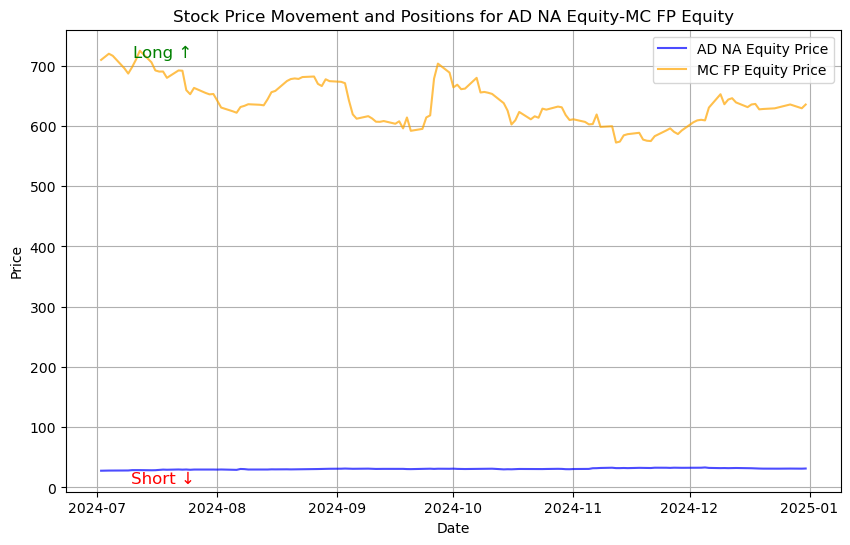

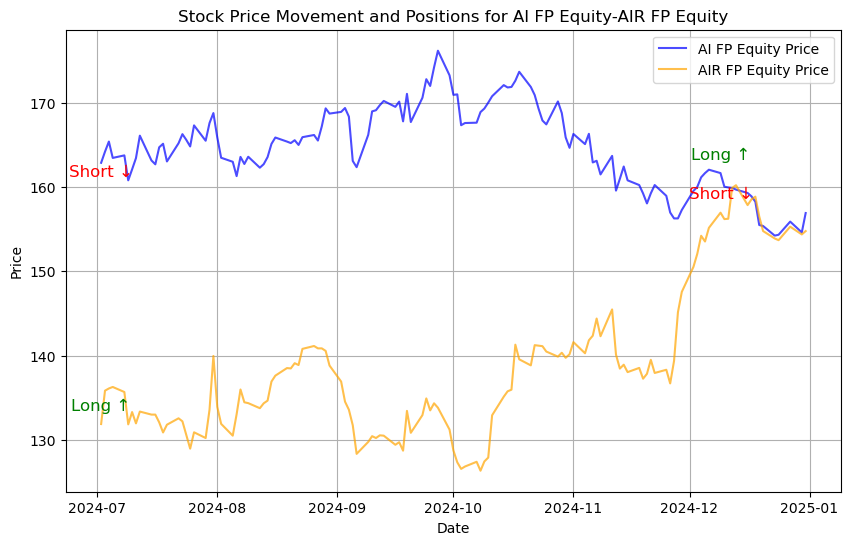

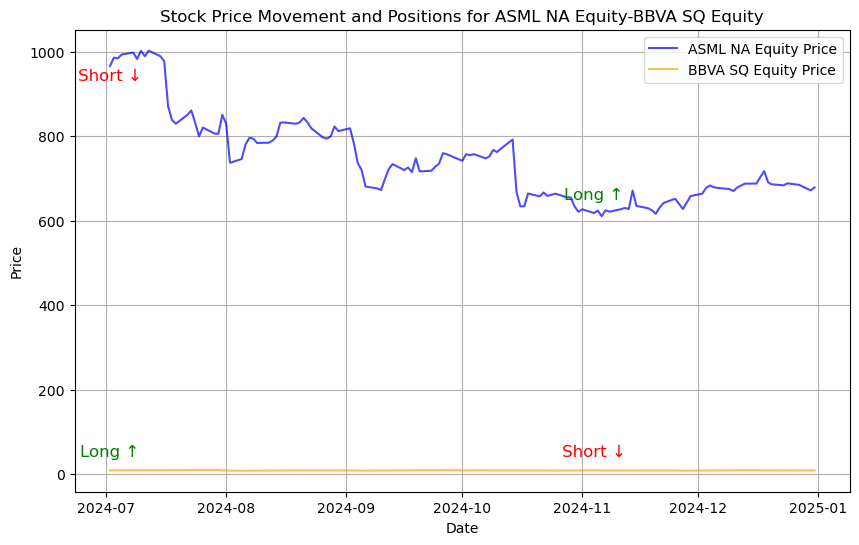

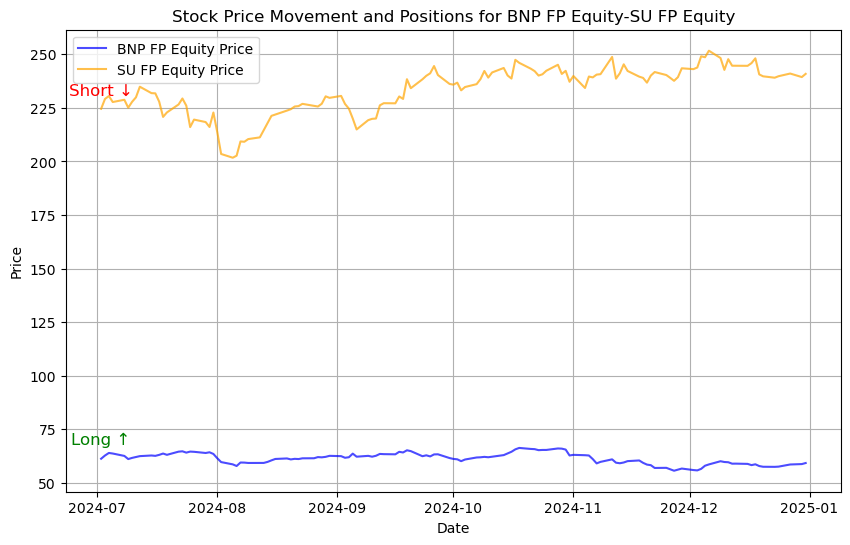

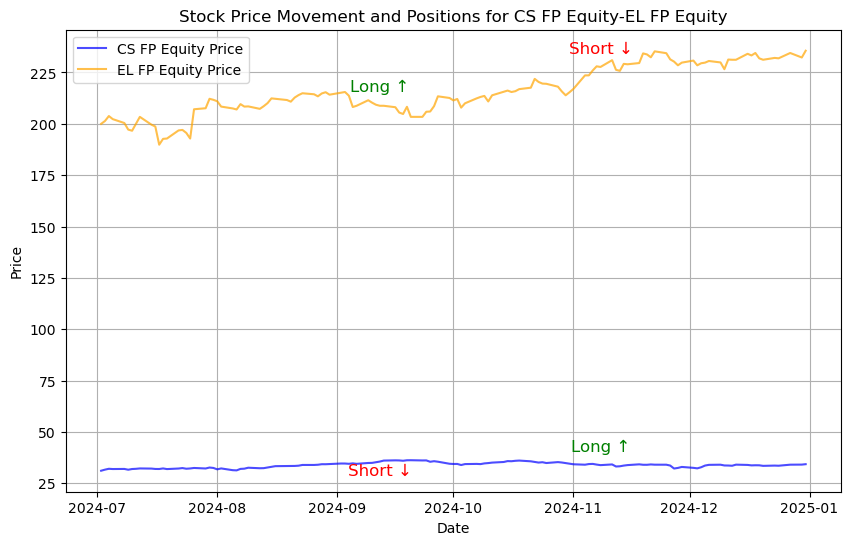

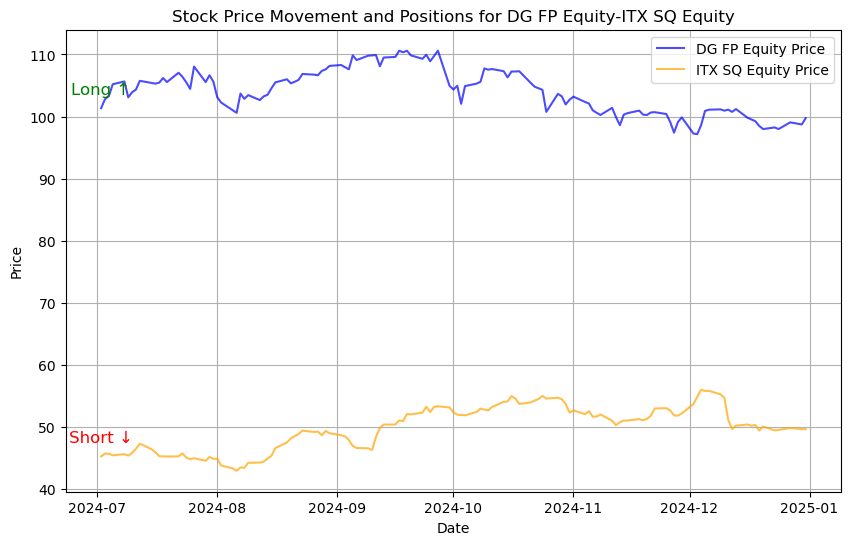

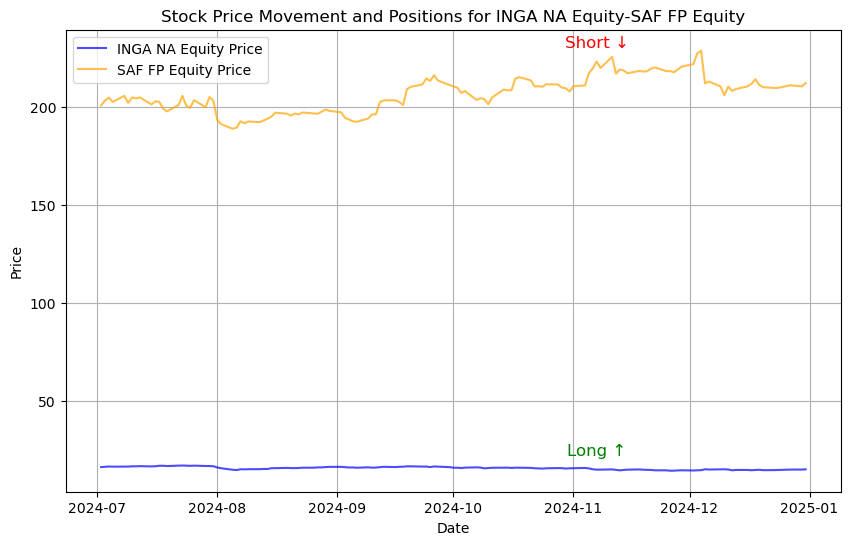

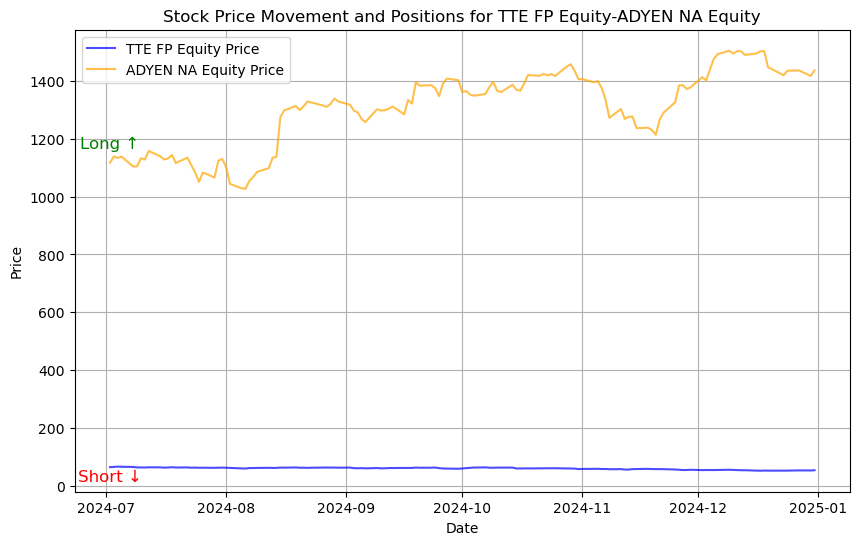

In [23]:
def plot_pair_positions(pair, position_history_df, prices_trade):
    s1, s2 = parse_pair(pair)
    stock1_prices = prices_trade[s1]
    stock2_prices = prices_trade[s2]
    pair_history = position_history_df[position_history_df['Pair'] == pair]

    plt.figure(figsize=(10, 6))
    plt.plot(stock1_prices.index, stock1_prices, label=f'{s1} Price', color='blue', alpha=0.7)
    plt.plot(stock2_prices.index, stock2_prices, label=f'{s2} Price', color='orange', alpha=0.7)

    # Annotate positions (Long/Short) on the plot
    for _, row in pair_history.iterrows():
        position = row['Position']
        date = row['Date']
        
        if position == 'Long':
            plt.annotate('Long ↑', (date, stock1_prices.loc[date]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='green', fontsize=12)
            plt.annotate('Short ↓', (date, stock2_prices.loc[date]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='red', fontsize=12)
        elif position == 'Short':
            plt.annotate('Short ↓', (date, stock1_prices.loc[date]),
                         textcoords="offset points", xytext=(0, -10), ha='center', color='red', fontsize=12)
            plt.annotate('Long ↑', (date, stock2_prices.loc[date]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='green', fontsize=12)

    plt.title(f"Stock Price Movement and Positions for {pair}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

prices_trade.index = pd.to_datetime(prices_trade.index)
position_history_df['Date'] = pd.to_datetime(position_history_df['Date'])

for pair in selected_pairs:
    plot_pair_positions(pair, position_history_df, prices_trade)

### Plotting the Spread

In [24]:
def plot_spread_and_positions(pair, prices_trade, log_prices_form, log_prices_trade, r=1.25):
    # Parse the pair
    s1, s2 = parse_pair(pair)

    # Fit the OLS model to calculate the spread
    model = sm.OLS(log_prices_form[s1], sm.add_constant(log_prices_form[s2]))
    res = model.fit()
    mu = res.resid.mean()  # Mean of the spread
    sigma = res.resid.std()  # Standard deviation of the spread
    spread = log_prices_trade[s1] - res.predict(sm.add_constant(log_prices_trade[s2]))

    # Thresholds
    upper_threshold = mu + r * sigma
    lower_threshold = mu - r * sigma

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot the spread
    plt.plot(spread.index, spread, label='Spread', color='blue', alpha=0.7)
    plt.axhline(mu, color='black', linestyle='--', label='Mean (µ)')
    plt.axhline(upper_threshold, color='red', linestyle='--', label=f'Upper Threshold (µ + {r}σ)')
    plt.axhline(lower_threshold, color='green', linestyle='--', label=f'Lower Threshold (µ - {r}σ)')

    # Determine positions for annotations
    position = 0
    for t in spread.index:
        if spread[t] > upper_threshold:
            # Short signal
            if position != -1:
                plt.annotate('Short ↓', (t, spread[t]),
                             textcoords="offset points", xytext=(0, -10), ha='center', color='red', fontsize=12)
                position = -1
        elif spread[t] < lower_threshold:
            # Long signal
            if position != 1:
                plt.annotate('Long ↑', (t, spread[t]),
                             textcoords="offset points", xytext=(0, 10), ha='center', color='green', fontsize=12)
                position = 1
        #else:
            # No change in position
         #   position = 0

    # Add labels, legend, and grid
    plt.title(f"Spread and Trading Signals for {pair}")
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

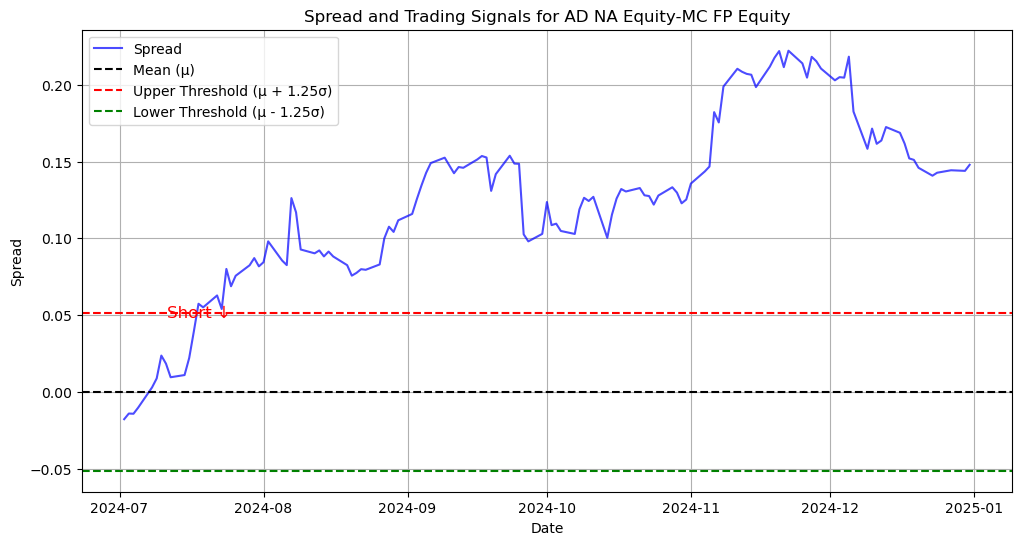

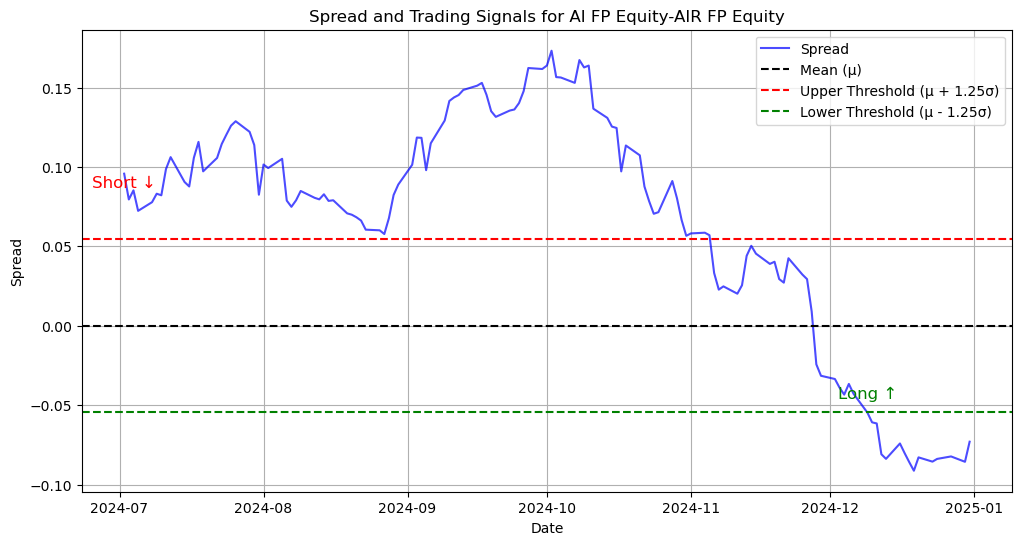

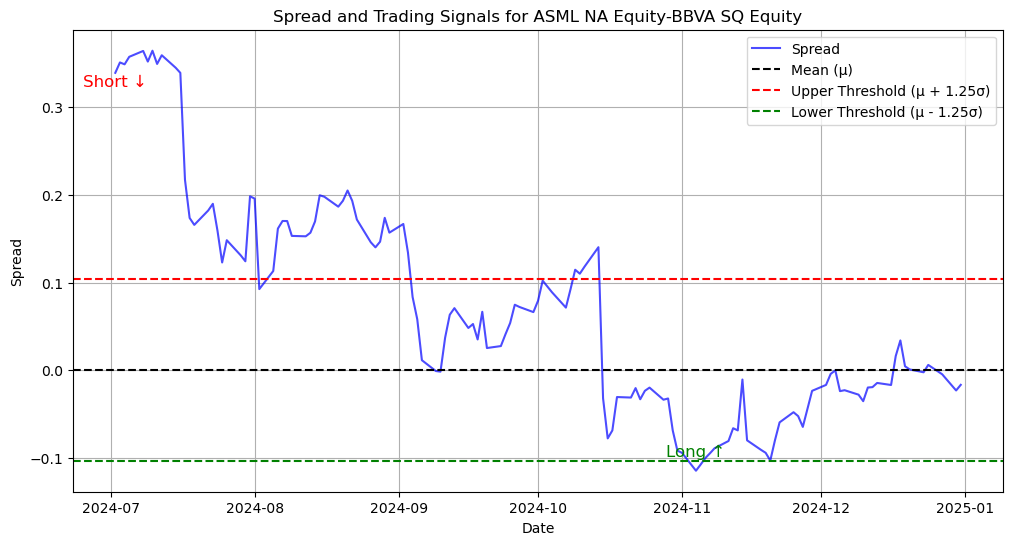

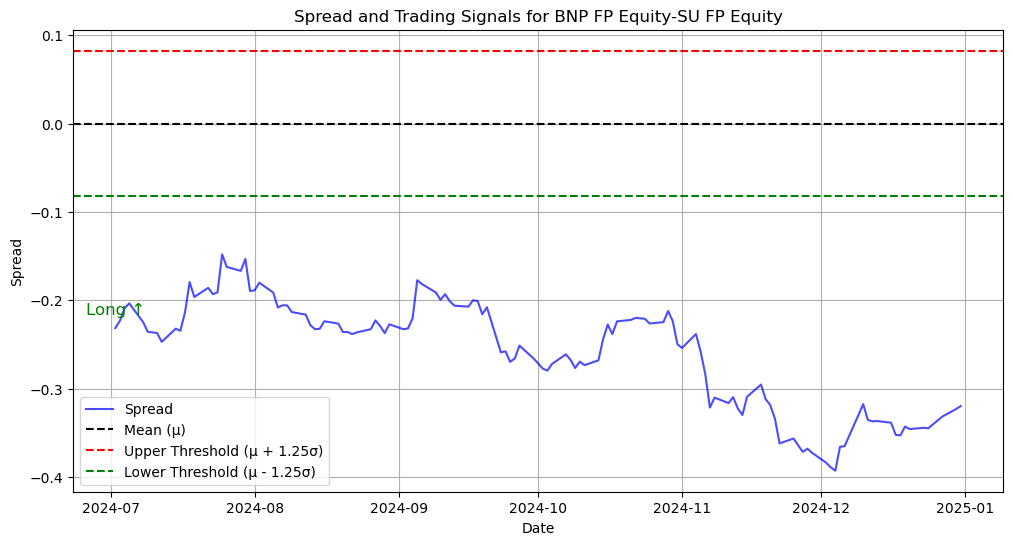

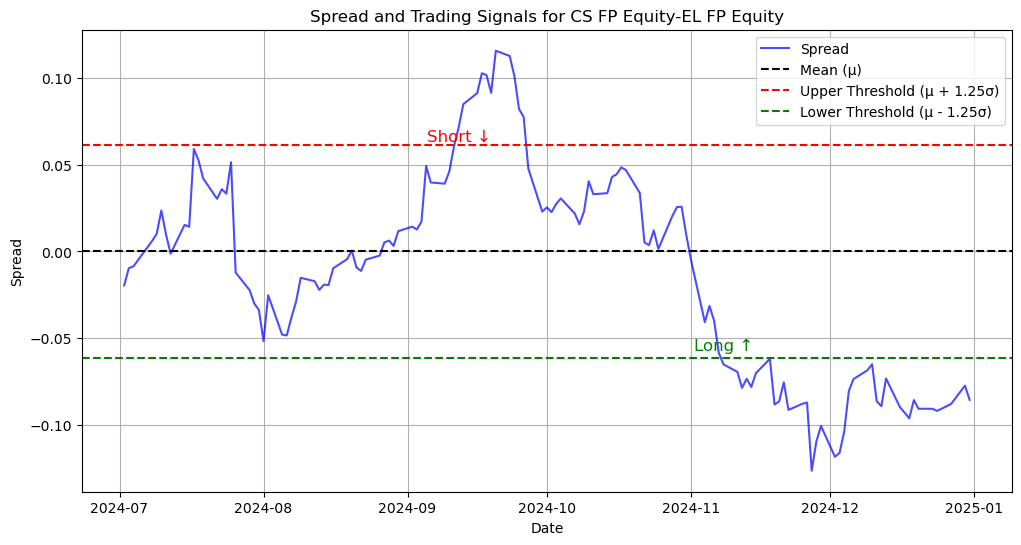

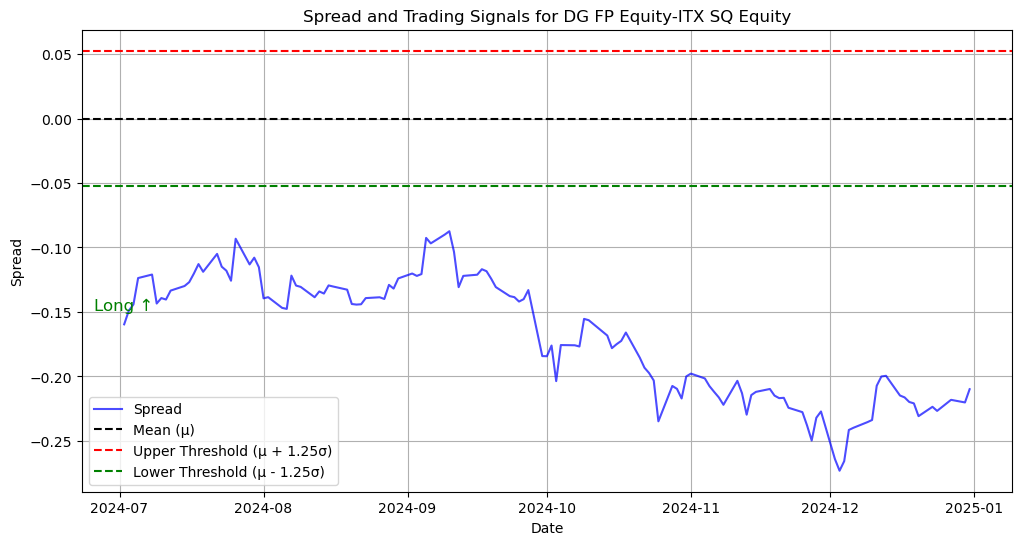

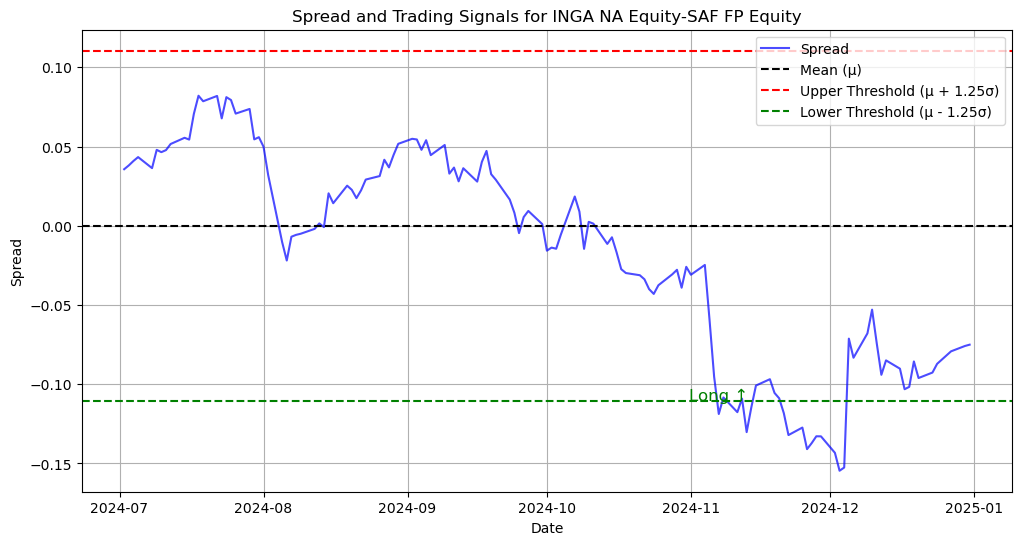

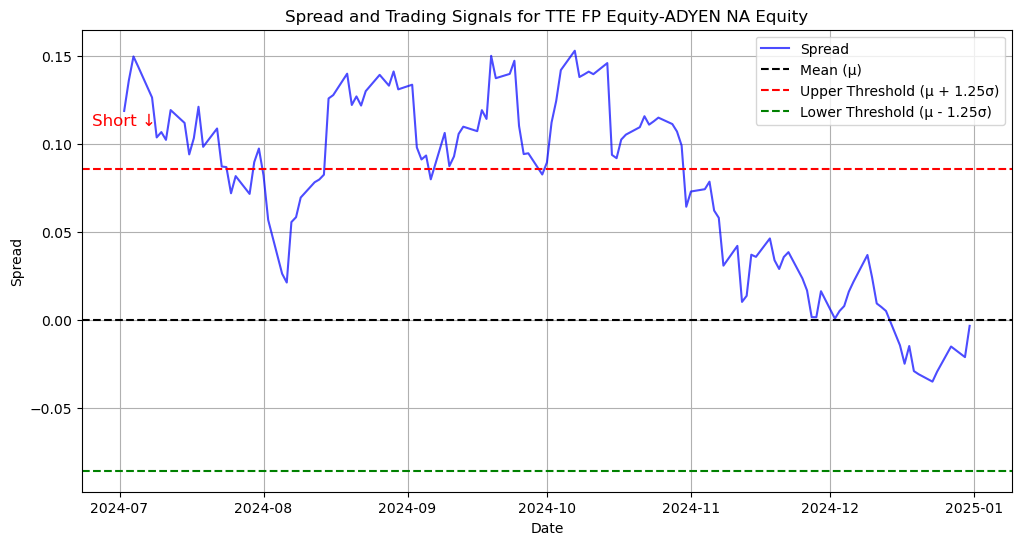

In [25]:
log_prices_trade.index = pd.to_datetime(log_prices_trade.index)

for pair in selected_pairs:
    plot_spread_and_positions(pair, prices_trade, log_prices_form, log_prices_trade, r=1.25)